In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

#We define the function f_0 , the sum of the fi, and the function f: 
def f_0(v,Q,p):
    return(v.T.dot(Q.dot(v))+p.T.dot(v))

def sum_f_i(v,A,b):
    return(np.sum(np.log(b-A.dot(v))))

def f(Q,p,A,b,v,t):
    for i in range(len(b)):
        if  A.dot(v)[i]-b[i]>0:
                raise Exception('Error, Unfeasible point')
    return(t*f_0(v,Q,p)-sum_f_i(v,A,b))

#Then we define the gradients

def grad_f_0(v,Q,p):
    return((Q+Q.T).dot(v)+p.reshape(-1,1))   #It is 2*Q.v if the matrix is symmetric 

def sum_grad_f_i(v,A,b):
    return((-np.sum(A.T/(A.dot(v)-b).T,axis=1)).reshape(-1,1))

def grad_f(Q,p,A,b,v,t):
    return(t*grad_f_0(v,Q,p)+sum_grad_f_i(v,A,b))

#Finally, we define the Hessian, since the centering step will be solve with the Newton's method and the 
#backtrackting line search 

def Hessian_f_0(v,Q,p):
    return(Q+Q.T)

def sum_Hessian_f_i(v,A,b):
    somme=np.zeros((n,n))
    n1=len(A[0,:])
    d=len(A[:,0])
    for i in range(d):
        a=(A[i,:]).reshape(n1,1)
        at=(A[i,:]).reshape(1,n1)
        somme+=((a*at)/(((A.dot(v))[i]-b[i])**2)).reshape(n1,n1)
    return(somme)

def Hessian_f(Q,p,A,b,v,t):
    return(t*Hessian_f_0(v,Q,p)+sum_Hessian_f_i(v,A,b))
    

#We will eventually use an exact line search, so we need to set alpha and beta parameters

alpha=0.1 #Usual parameters
beta=0.7


def back_line_search(Q,p,A,b,t,v,alpha,beta,delta_v):
    t_bls=1
    while not(((b-A.dot(v+t_bls*delta_v))>0).all()) or f(Q,p,A,b,(v+t_bls*delta_v),t)>=f(Q,p,A,b,v,t)+alpha*t_bls*(grad_f(Q,p,A,b,v,t).T.dot(delta_v)):
        t_bls=beta*t_bls
    return(t_bls)

#The algorithm for the centering step, with a precise value of t
def centering_step(Q,p,A,b,t,v0,eps):
    n_iter=0
    incr=[v0]
    delta_v=-(np.linalg.inv(Hessian_f(Q,p,A,b,v0,t))).dot(grad_f(Q,p,A,b,v0,t))  
    #The step is chosen with the Newton technic
    lamb2=(grad_f(Q,p,A,b,v0,t).T.dot(np.linalg.inv(Hessian_f(Q,p,A,b,v0,t)))).dot(grad_f(Q,p,A,b,v0,t))
    while lamb2/2>eps:
            t_bls=back_line_search(Q,p,A,b,t,v0,alpha,beta,delta_v)
            n_iter+=1
            v0=v0+t_bls*delta_v
            incr+=[v0]
            delta_v=-(np.linalg.inv(Hessian_f(Q,p,A,b,v0,t))).dot(grad_f(Q,p,A,b,v0,t))  
            lamb2=(grad_f(Q,p,A,b,v0,t).T.dot(np.linalg.inv(Hessian_f(Q,p,A,b,v0,t)))).dot(grad_f(Q,p,A,b,v0,t))
    return(incr, n_iter)


#Now the barrier method, t will increase as long as m/t<eps, where m is the number of constraints,
#Here it is basically the dimension of the vector b, that is 2*d

def barrier_method(Q,p,A,b,v0,eps,mu):
    t=1 #Must be tuned
    #Mu is tuned at the end with the plots
    iterates=[v0]
    n_iters=[0]
    m=2*d
    cpt=0
    while m/t>=eps:
        increment,n_iter=centering_step(Q,p,A,b,t,v0,eps)
        update=increment[-1]
        v0=update
        iterates+=[v0]
        cpt+=n_iter
        n_iters+=[cpt]
        t=mu*t
    return(iterates,n_iters)
        
        

Norm of the solution for mu = 2 and eps=0.0001 :  5.762483612138001
Norm of the solution for mu = 5 and eps=0.0001 :  5.762483311614942
Norm of the solution for mu = 15 and eps=0.0001 :  5.762483544036041
Norm of the solution for mu = 50 and eps=0.0001 :  5.762482300573326
Norm of the solution for mu = 100 and eps=0.0001 :  5.7624836033588736
Norm of the solution for mu = 250 and eps=0.0001 :  5.76248082746152
Norm of the solution for mu = 2 and eps=0.001 :  5.76248236299348
Norm of the solution for mu = 5 and eps=0.001 :  5.762481395642071
Norm of the solution for mu = 15 and eps=0.001 :  5.762480195592415
Norm of the solution for mu = 50 and eps=0.001 :  5.762482300578256
Norm of the solution for mu = 100 and eps=0.001 :  5.762465196768321
Norm of the solution for mu = 250 and eps=0.001 :  5.762480828037674


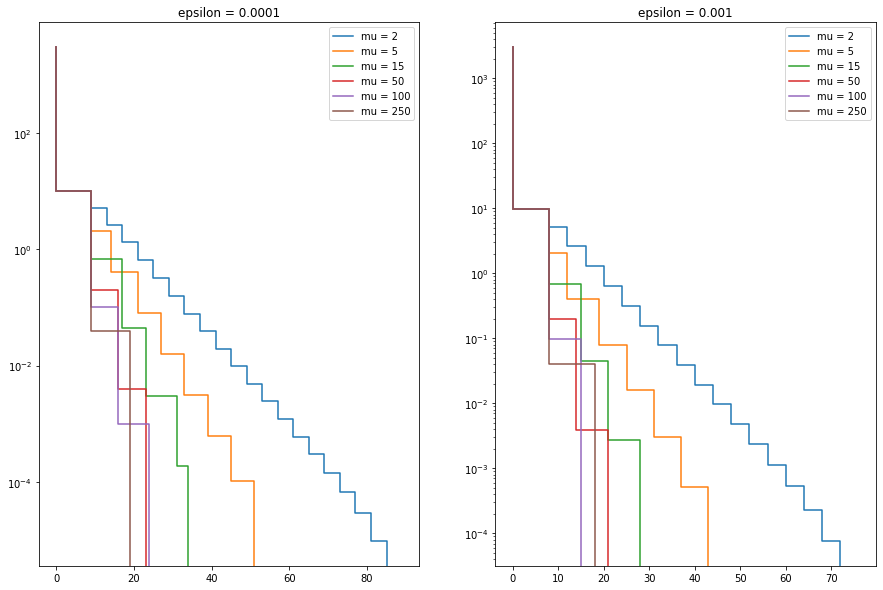

In [24]:
#X is of dimensions nxd (and we need n<<d, so we will set for instance n=10 and d=75)
n = 10
d = 75

#We generate the random data
np.random.seed(10)
x,y=make_regression(n_samples=n,n_features=d,noise=10) #The number of required iterations will depend on the noise

#We need the parameters b, A, Q, p, that we compute from results of question 1

Q=0.5*np.identity(n)

lamb=10
b=np.ones((2*d,1))
b=lamb*b

p=-y.reshape(-1,1)

A=np.vstack((x.T,-x.T))

eps=0.0001

#One of the main difficulties is to find a feasible point to start, but since b is a positive vector,
#we can set v0=0 to be sure to have Av-b<0 at the beginning 

v0=np.zeros((n,1))

mu_list=np.array([2,5,15,50,100,250])

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("epsilon = {}".format(eps))
for i in range(len(mu_list)):     #We try for different values of mu
    mu=mu_list[i]
    values,nb_iters=barrier_method(Q,p,A,b,v0,eps,mu)
    #We get the optimum (so the last vector of the list of vector from the barrier function), and the optimal value
    optimum=values[-1]
    print('Norm of the solution for mu = {} and eps={} : '.format(mu,eps), np.linalg.norm(optimum))
    optimal_value=f_0(optimum,Q,p)
    #We will have an array, with all the distances to the optimum 
    diff=np.zeros(len(nb_iters)) 
    for j in range(len(nb_iters)):
        #Each new j corresponds to a full algorithm of Newton for a fixed t
        value=values[j]
        diff[j]=f_0(value,Q,p)-optimal_value
    plt.step(nb_iters,diff,label = 'mu = {}'.format(mu))
plt.legend()
plt.semilogy()
eps=0.001
plt.subplot(1,2,2)
plt.title("epsilon = {}".format(eps))
for i in range(len(mu_list)):     #We try for different values of mu
    mu=mu_list[i]
    values,nb_iters=barrier_method(Q,p,A,b,v0,eps,mu)
    #We get the optimum (so the last vector of the list of vector from the barrier function), and the optimal value
    optimum=values[-1]
    print('Norm of the solution for mu = {} and eps={} : '.format(mu,eps), np.linalg.norm(optimum))
    optimal_value=f_0(optimum,Q,p)
    #We will have an array, with all the distances to the optimum 
    diff=np.zeros(len(nb_iters)) 
    for j in range(len(nb_iters)):
        #Each new j corresponds to a full algorithm of Newton for a fixed t
        value=values[j]
        diff[j]=f_0(value,Q,p)-optimal_value
    plt.step(nb_iters,diff,label = 'mu = {}'.format(mu))
plt.legend()
plt.semilogy()
plt.show()



